In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from tensorflow import keras
#from keras import models,layers
import matplotlib.pyplot as plt
from matplotlib.pylab import *
from sklearn.model_selection import train_test_split
import timeit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.lines import Line2D
from geopy.distance import geodesic

In [2]:
def nn_model(n1,n2,n3,n4,n5,n6):
    #NN model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n1,  kernel_initializer='normal', activation=tf.nn.relu, input_shape=(n1,)),
#         tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(n2, activation=tf.nn.relu),
        tf.keras.layers.Dense(n3, activation=tf.nn.relu),
        tf.keras.layers.Dense(n4, activation=tf.nn.relu),
        tf.keras.layers.Dense(n5, activation=tf.nn.relu),
        tf.keras.layers.Dense(n6, activation=tf.nn.relu),
        tf.keras.layers.Dense(2)  
    ])
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
def train(in_train, out_train, in_test, out_test, num_epochs):
    #Train model
    num_features = in_train.shape[1] 
    if num_features == 189:
        n1,n2,n3 = 189,126,126
    elif num_features == 512:   ##Diff
        n1,n2,n3,n4,n5,n6 = 512,400,342,200,100,100

    model = nn_model(n1,n2,n3,n4,n5,n6)
    time_before = time.time()
    history = model.fit(in_train.to_numpy(), 
              out_train.to_numpy(), 
              epochs=num_epochs, 
              verbose=1,
              validation_split = 0.2
             )
    time_after = time.time()
    training_time_per_epoch = (time_after-time_before)/num_epochs #time.time() assigns the current time since 1970, this here assigns the timestamp  before and after epoching 
    evaluation = model.evaluate(in_test.to_numpy(), out_test.to_numpy()) # gives test loss, test acc
    model.save('Highway_regression_cosine_middle_old.h5')
    return history.history , training_time_per_epoch, evaluation

In [4]:
def test(weights, in_test, out_test): #takes in the model 
    time_before_loading = time.time()
    model = weights
    
    time_after_loading = time.time()
    loading_time = time_after_loading - time_before_loading
    
    time_before_prediction = time.time()
    predictions = model.predict(in_test)
    time_after_prediction = time.time()
    prediction_time_per_sample = (time_after_prediction - time_before_prediction)/in_test.shape[0]
    
    return predictions, loading_time, prediction_time_per_sample

In [5]:
def get_final_location(data, predictions_df):
    
    #estimate location using cosine similarity
    
    dx = 2e-05 ; dy = 2e-05 #Area in which cosine similarity is calulated
    n = 5          #Number of similar traces
    time_cosine = 0
    
    test_set = predictions_df.drop(['Y(Lat)','X(Lon)', 'Y(Lat)_NN_estimated','X(Lon)_NN_estimated'], axis = 1)
    
    f_x = []
    f_y = []
    for i in range(predictions_df.shape[0]): # 1500 iterations
#         print(predctions_df.shape[0]) 
        start_cosine = timeit.default_timer()
        in_test_i = test_set.iloc[i]
#         print(in_test_i)
        p_x = predictions_df.iloc[i,:]['X(Lon)_NN_estimated']
        p_y = predictions_df.iloc[i,:]['Y(Lat)_NN_estimated']
            
        c1 = (data['Y(Lat)']>(p_y-dy)) & (data['Y(Lat)']<(p_y+dy)) 
        df_c = data.loc[c1,:]
        
        c2 = (df_c['X(Lon)']>(p_x-dx)) & (df_c['X(Lon)']<(p_x+dx))
        df_c = df_c.loc[c2,:]
        if df_c.shape[0]==0:
            final_x = np.nan
            final_y = np.nan
            print('Not found')
        else:
            z = cosine_similarity(df_c.drop(['X(Lon)','Y(Lat)'], axis = 1), in_test_i.to_frame().T)
        
            arg = z.argsort(axis=0)[-n:][::-1].reshape(1,n).tolist()   
    
            val_x = df_c.loc[df_c.index[tuple(arg)],'X(Lon)'].values
            val_y = df_c.loc[df_c.index[tuple(arg)],'Y(Lat)'].values
        
            weight = z[tuple(arg)].reshape(n)
        
            weighted_sum_x = np.multiply(val_x,np.square(weight)).sum()
            weighted_sum_y = np.multiply(val_y,np.square(weight)).sum()
            final_x = np.divide(weighted_sum_x, np.sum(np.square(weight)))
            final_y = np.divide(weighted_sum_y, np.sum(np.square(weight)))
            stop_cosine = timeit.default_timer()
            time_cosine = time_cosine + (stop_cosine - start_cosine)
        
        f_x.append(final_x)
        f_y.append(final_y)
    predictions_df['X(Lon)_NN_cosine_estimated'] = f_x
    predictions_df['Y(Lat)_NN_cosine_estimated'] = f_y
    
    return predictions_df
    

In [6]:
def distance(test):
    
    #Calculate distance between ground truth and estimation
    
    dis = []
    y_truth = test['Y(Lat)'].values
    x_truth = test['X(Lon)'].values
    y_estimation = test['Y(Lat)_NN_cosine_estimated'].values
    x_estimation = test['X(Lon)_NN_cosine_estimated'].values
    for sample in range(test.shape[0]):
        g_truth = (y_truth[sample], x_truth[sample])
        estimation = (y_estimation[sample], x_estimation[sample])
        d = geodesic(g_truth, estimation).km*1000 #measures distance btween 2 locations using the shortest distance on the surface of an ellipsoidal model of the earth
        dis.append(d)
    mean = np.mean(dis)
    std = np.std(dis)
    return dis, mean, std    

In [7]:
#load train data

dic = {}
for i in range(512):
    dic[str(i)] = i
#df_high = pd.read_csv('multiple_points_highway.csv')
df_high = pd.read_csv(r"C:\Users\asus\Documents\GPR_Dataset\New Reference\multiple_points_highway.csv")
# df_high = pd.read_hdf("Combined_Training_Data_1_to_27.hd5", 'table')
df_high.rename(columns=dic, inplace=True)
data = df_high.drop(['GPR_Trace', 'Elevation', 'Position_on_Lane'], axis = 1) #will be dropped from the data, will still not change in in df_high   
                                                                              #dropped because they aren't to be predicted, only Lat. Y and Long. X

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,516) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
df_high

,GPR_Trace,Y(Lat),X(Lon),Elevation,0,1,2,3,4,5,...,503,504,505,506,507,508,509,510,511,Position_on_Lane
0,25001,49.451282,7.732013,309.7054,0.0,-1.000000,2.0,-2.0,2.0,-2.0,...,-7.000000,-25.000000,-40.000000,-14.000000,17.0,37.000000,44.00,66.000000,8.000000,-10
1,25002,49.451282,7.732013,309.7049,-1.0,0.000000,0.0,0.0,0.0,0.0,...,164.000000,215.000000,208.000000,158.000000,106.0,102.000000,74.00,73.000000,16.000000,-10
2,25003,49.451282,7.732014,309.7045,2.0,-2.000000,2.0,-2.0,2.0,-2.0,...,-42.000000,-65.000000,-88.000000,-84.000000,-42.0,23.000000,60.00,59.000000,3.000000,-10
3,25004,49.451283,7.732015,309.7040,0.0,0.000000,1.0,-1.0,1.0,0.0,...,83.000000,65.000000,63.000000,58.000000,48.0,72.000000,57.00,63.000000,9.000000,-10
4,25005,49.451283,7.732015,309.7036,0.0,0.000000,1.0,-1.0,2.0,-2.0,...,-6.000000,11.000000,-4.000000,-14.000000,-2.0,45.000000,47.00,58.000000,9.000000,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26651,27000_45662_7,49.451724,7.733221,NaN,-3.0,0.416667,0.0,0.0,0.0,0.0,...,21.666667,-13.333333,-45.833333,-41.916667,-31.0,-7.333333,-5.75,44.416667,18.083333,Between
26652,27000_45662_8,49.451723,7.733223,NaN,-3.0,0.333333,0.0,0.0,0.0,0.0,...,10.333333,-15.666667,-37.666667,-28.333333,-16.0,4.333333,6.00,49.333333,18.666667,Between
26653,27000_45662_9,49.451722,7.733224,NaN,-3.0,0.250000,0.0,0.0,0.0,0.0,...,-1.000000,-18.000000,-29.500000,-14.750000,-1.0,16.000000,17.75,54.250000,19.250000,Between
26654,27000_45662_10,49.451721,7.733225,NaN,-3.0,0.166667,0.0,0.0,0.0,0.0,...,-12.333333,-20.333333,-21.333333,-1.166667,14.0,27.666667,29.50,59.166667,19.833333,Between


In [9]:
data  #dropped elevetaion, GPR_Trace as well as the position in lane, last column

#This is the training data 

,Y(Lat),X(Lon),0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,49.451282,7.732013,0.0,-1.000000,2.0,-2.0,2.0,-2.0,3.0,3.00,...,16.00,-7.000000,-25.000000,-40.000000,-14.000000,17.0,37.000000,44.00,66.000000,8.000000
1,49.451282,7.732013,-1.0,0.000000,0.0,0.0,0.0,0.0,0.0,-2.00,...,92.00,164.000000,215.000000,208.000000,158.000000,106.0,102.000000,74.00,73.000000,16.000000
2,49.451282,7.732014,2.0,-2.000000,2.0,-2.0,2.0,-2.0,3.0,-2.00,...,-25.00,-42.000000,-65.000000,-88.000000,-84.000000,-42.0,23.000000,60.00,59.000000,3.000000
3,49.451283,7.732015,0.0,0.000000,1.0,-1.0,1.0,0.0,-1.0,-15.00,...,92.00,83.000000,65.000000,63.000000,58.000000,48.0,72.000000,57.00,63.000000,9.000000
4,49.451283,7.732015,0.0,0.000000,1.0,-1.0,2.0,-2.0,5.0,9.00,...,-17.00,-6.000000,11.000000,-4.000000,-14.000000,-2.0,45.000000,47.00,58.000000,9.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26651,49.451724,7.733221,-3.0,0.416667,0.0,0.0,0.0,0.0,0.0,-3.25,...,40.75,21.666667,-13.333333,-45.833333,-41.916667,-31.0,-7.333333,-5.75,44.416667,18.083333
26652,49.451723,7.733223,-3.0,0.333333,0.0,0.0,0.0,0.0,0.0,-3.00,...,25.00,10.333333,-15.666667,-37.666667,-28.333333,-16.0,4.333333,6.00,49.333333,18.666667
26653,49.451722,7.733224,-3.0,0.250000,0.0,0.0,0.0,0.0,0.0,-2.75,...,9.25,-1.000000,-18.000000,-29.500000,-14.750000,-1.0,16.000000,17.75,54.250000,19.250000
26654,49.451721,7.733225,-3.0,0.166667,0.0,0.0,0.0,0.0,0.0,-2.50,...,-6.50,-12.333333,-20.333333,-21.333333,-1.166667,14.0,27.666667,29.50,59.166667,19.833333


In [10]:
#load test data
test_set = pd.read_csv(r"C:\Users\asus\Documents\GPR_Dataset\New Reference\test_data.csv")

In [11]:
test_set

#This is the test data

,Y(Lat),X(Lon),0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,49.451284,7.732046,-3,3,-3,2,-2,1,0,-2,...,-46,-24,21,54,101,135,156,142,147,77
1,49.451284,7.732046,3,0,0,0,0,0,-1,3,...,8,2,-6,-16,-34,-45,-27,2,17,31
2,49.451284,7.732047,9,-2,0,0,0,0,0,0,...,-87,-80,-79,-73,-59,-16,16,48,8,21
3,49.451284,7.732047,10,-3,2,0,0,0,0,6,...,7,39,54,27,-52,-90,-142,-161,-161,-35
4,49.451284,7.732048,6,0,0,0,0,1,-1,2,...,-31,-48,-52,-21,9,24,-4,-38,-77,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,49.451618,7.732945,0,0,0,0,0,0,2,0,...,-26,-33,-23,-7,3,0,35,54,45,8
1496,49.451619,7.732946,-3,1,0,0,0,0,0,0,...,107,70,61,38,14,-29,-50,-40,31,17
1497,49.451619,7.732946,-3,2,-1,0,0,0,0,-3,...,89,52,-5,-65,-76,-45,8,20,31,20
1498,49.451619,7.732947,-2,1,0,0,0,0,0,2,...,-18,-64,-115,-146,-99,-55,-37,-22,13,13


In [12]:
#prepare train and test data

in_train = data.drop(['Y(Lat)', 'X(Lon)'], axis = 1) #features, with y data dropped, for the training 
out_train = data[['Y(Lat)', 'X(Lon)']] #prediction, y, for the training 
in_test = test_set.drop(['Y(Lat)', 'X(Lon)'], axis = 1) #features, with the prediction (latitude and longitude) data, y, dropped, for the testing
out_test = test_set[['Y(Lat)', 'X(Lon)']] #predictions, y, for the testing 

scaler = StandardScaler()   #distributing the data in a gaussian dist, mean = 0 and std = 1, import from sklearn preprocessing 
scaler.fit(in_train)        #usually a fit is done to the targeted set and then a transformation, see https://www.youtube.com/watch?v=ZddUwo4R5ug&ab_channel=StatsWire
in_train = pd.DataFrame(scaler.transform(in_train), columns=in_train.columns, index=in_train.index)
in_test =  pd.DataFrame(scaler.transform(in_test), columns=in_test.columns, index=in_test.index)

scaler_ = StandardScaler()
scaler_.fit(out_train)
out_train = pd.DataFrame(scaler_.transform(out_train), columns=out_train.columns, index=out_train.index)
out_test =  pd.DataFrame(scaler_.transform(out_test), columns=out_test.columns, index=out_test.index)

In [15]:
in_train.shape[1]
in_train 


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.213237,-0.689478,1.345295,-1.569166,1.694707,-1.704509,1.874054,0.514172,0.375852,-0.966191,...,0.130046,-0.175303,-0.474078,-0.666420,-0.332142,0.156950,0.380216,0.542636,0.756614,-0.060184
1,0.134872,-0.374954,0.385427,-0.368902,0.341399,-0.295518,0.177893,-0.690699,-1.064146,-2.043919,...,1.226115,2.295083,2.992774,2.920326,2.138566,1.427579,1.303900,0.966610,0.863607,0.096484
2,0.369968,-1.004001,1.345295,-1.569166,1.694707,-1.704509,1.874054,-0.690699,-0.424147,-1.274113,...,-0.461255,-0.680938,-1.051886,-1.360628,-1.337663,-0.685377,0.181269,0.768755,0.649620,-0.158102
3,0.213237,-0.374954,0.865361,-0.969034,1.018053,-0.295518,-0.387495,-3.823364,0.055852,0.111538,...,1.226115,1.124900,0.825992,0.823237,0.702108,0.599529,0.877584,0.726358,0.710759,-0.040601
4,0.213237,-0.374954,0.865361,-0.969034,1.694707,-1.704509,3.004829,1.960017,-0.904147,-1.889958,...,-0.345879,-0.160857,0.045950,-0.145763,-0.332142,-0.114308,0.493900,0.585033,0.634335,-0.040601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26651,-0.021860,-0.243902,0.385427,-0.368902,0.341399,-0.295518,0.177893,-0.991917,0.322519,0.650402,...,0.486990,0.238835,-0.305550,-0.750785,-0.733153,-0.528333,-0.249784,-0.160455,0.426717,0.137283
26652,-0.021860,-0.270113,0.385427,-0.368902,0.341399,-0.295518,0.177893,-0.931673,0.429185,0.727382,...,0.259844,0.075106,-0.339256,-0.632673,-0.538034,-0.314182,-0.083994,0.005601,0.501867,0.148706
26653,-0.021860,-0.296323,0.385427,-0.368902,0.341399,-0.295518,0.177893,-0.871430,0.535852,0.804363,...,0.032697,-0.088623,-0.372961,-0.514561,-0.342915,-0.100031,0.081795,0.171658,0.577018,0.160130
26654,-0.021860,-0.322533,0.385427,-0.368902,0.341399,-0.295518,0.177893,-0.811186,0.642518,0.881343,...,-0.194449,-0.252352,-0.406667,-0.396449,-0.147796,0.114120,0.247585,0.337715,0.652168,0.171554


# Train - Test

In [22]:
history, training_time_per_epoch, evaluation = train(in_train, out_train, in_test, out_test, 10) #last in the number of epochs
#evaluation gives test loss and acc.

model = keras.models.load_model('Highway_regression_cosine_middle_old.h5') #load model

predictions, loading_time, prediction_time_per_sample = test(model, in_test, out_test) #test- get NN estimation
inversed_predictions = scaler_.inverse_transform(predictions) #inverse scale
predictions_df = pd.DataFrame()
test_df = data.loc[in_test.index,:]
predictions_NN_df = test_set.copy()

predictions_NN_df['X(Lon)_NN_estimated'] = inversed_predictions[:,1]
predictions_NN_df['Y(Lat)_NN_estimated'] = inversed_predictions[:,0]

Epoch 1/10
667/667 [==============================] - 2s 4ms/step - loss: 0.2545 - accuracy: 0.6324 - val_loss: 0.4730 - val_accuracy: 0.4769
Epoch 2/10
667/667 [==============================] - 2s 4ms/step - loss: 0.1119 - accuracy: 0.7146 - val_loss: 0.2791 - val_accuracy: 0.6791
Epoch 3/10
667/667 [==============================] - 3s 4ms/step - loss: 0.0770 - accuracy: 0.7706 - val_loss: 0.3605 - val_accuracy: 0.6302
Epoch 4/10
667/667 [==============================] - 4s 5ms/step - loss: 0.0630 - accuracy: 0.8040 - val_loss: 0.2164 - val_accuracy: 0.6930
Epoch 5/10
667/667 [==============================] - 3s 5ms/step - loss: 0.0501 - accuracy: 0.8284 - val_loss: 0.3022 - val_accuracy: 0.6733
Epoch 6/10
667/667 [==============================] - 3s 4ms/step - loss: 0.0453 - accuracy: 0.8393 - val_loss: 0.1757 - val_accuracy: 0.6814
Epoch 7/10
667/667 [==============================] - 2s 3ms/step - loss: 0.0436 - accuracy: 0.8416 - val_loss: 0.2741 - val_accuracy: 0.6862
Epoch 

In [23]:
predictions_NN_df

,Y(Lat),X(Lon),0,1,2,3,4,5,6,7,...,504,505,506,507,508,509,510,511,X(Lon)_NN_estimated,Y(Lat)_NN_estimated
0,49.451284,7.732046,-3,3,-3,2,-2,1,0,-2,...,21,54,101,135,156,142,147,77,7.732371,49.451401
1,49.451284,7.732046,3,0,0,0,0,0,-1,3,...,-6,-16,-34,-45,-27,2,17,31,7.732428,49.451424
2,49.451284,7.732047,9,-2,0,0,0,0,0,0,...,-79,-73,-59,-16,16,48,8,21,7.732282,49.451366
3,49.451284,7.732047,10,-3,2,0,0,0,0,6,...,54,27,-52,-90,-142,-161,-161,-35,7.732975,49.451630
4,49.451284,7.732048,6,0,0,0,0,1,-1,2,...,-52,-21,9,24,-4,-38,-77,8,7.732995,49.451630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,49.451618,7.732945,0,0,0,0,0,0,2,0,...,-23,-7,3,0,35,54,45,8,7.732217,49.451344
1496,49.451619,7.732946,-3,1,0,0,0,0,0,0,...,61,38,14,-29,-50,-40,31,17,7.732539,49.451458
1497,49.451619,7.732946,-3,2,-1,0,0,0,0,-3,...,-5,-65,-76,-45,8,20,31,20,7.732790,49.451553
1498,49.451619,7.732947,-2,1,0,0,0,0,0,2,...,-115,-146,-99,-55,-37,-22,13,13,7.732215,49.451344


In [24]:

predictions_final_df = get_final_location(data, predictions_NN_df)  #Calculate final estimation using cosine similarity
predictions_final_df.dropna(axis=0, inplace=True) 



In [25]:
dis, mean, std  = distance(predictions_final_df) #distance b/w ground truth and estimation, mean and standard deviation

In [26]:
print(dis, mean, std)

[26.856718013900878, 30.1698788781517, 18.327243601317463, 79.38021757853313, 79.61124763866886, 66.88211561591069, 70.91449808769553, 73.63962801878421, 78.46344246164698, 70.75365632523973, 78.32934735999183, 10.52721343974982, 79.69476143406196, 73.00059677827232, 64.43728813529825, 66.34704355851201, 77.93267550685833, 21.77364785103807, 22.025660537118895, 73.22129152947743, 79.39712452777673, 79.23713951706459, 15.591306548013463, 16.13693068749019, 72.99819193661948, 70.07004118538894, 70.51926709225125, 73.1769436372863, 71.90915494759948, 69.50826034737202, 71.95116708927291, 63.027093838425074, 8.77929761359762, 42.34680121798616, 0.28081366252387047, 20.85576354415141, 1.2629114922138125, 16.02003114741398, 20.171011250669547, 63.178051045370594, 20.459232386593207, 20.308984700895003, 19.89811403930939, 20.09100348311872, 9.453833266930438, 13.005412453194637, 68.5708518630195, 20.161042775245296, 69.3437253411649, 11.311920354294951, 22.729454602981225, 37.00559407822991, 

-----------------------------------------
### Plots

In [27]:
(7.732305+7.732628+
7.732191+7.732344+
7.732281)/5

7.7323498

In [28]:
predictions_final_df[['X(Lon)_NN_estimated']]

,X(Lon)_NN_estimated
0,7.732371
1,7.732428
2,7.732282
3,7.732975
4,7.732995
...,...
1495,7.732217
1496,7.732539
1497,7.732790
1498,7.732215


In [29]:
predictions_final_df

,Y(Lat),X(Lon),0,1,2,3,4,5,6,7,...,506,507,508,509,510,511,X(Lon)_NN_estimated,Y(Lat)_NN_estimated,X(Lon)_NN_cosine_estimated,Y(Lat)_NN_cosine_estimated
0,49.451284,7.732046,-3,3,-3,2,-2,1,0,-2,...,101,135,156,142,147,77,7.732371,49.451401,7.732372,49.451397
1,49.451284,7.732046,3,0,0,0,0,0,-1,3,...,-34,-45,-27,2,17,31,7.732428,49.451424,7.732413,49.451412
2,49.451284,7.732047,9,-2,0,0,0,0,0,0,...,-59,-16,16,48,8,21,7.732282,49.451366,7.732273,49.451357
3,49.451284,7.732047,10,-3,2,0,0,0,0,6,...,-52,-90,-142,-161,-161,-35,7.732975,49.451630,7.732994,49.451643
4,49.451284,7.732048,6,0,0,0,0,1,-1,2,...,9,24,-4,-38,-77,8,7.732995,49.451630,7.732999,49.451642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,49.451618,7.732945,0,0,0,0,0,0,2,0,...,3,0,35,54,45,8,7.732217,49.451344,7.732216,49.451347
1496,49.451619,7.732946,-3,1,0,0,0,0,0,0,...,14,-29,-50,-40,31,17,7.732539,49.451458,7.732525,49.451463
1497,49.451619,7.732946,-3,2,-1,0,0,0,0,-3,...,-76,-45,8,20,31,20,7.732790,49.451553,7.732796,49.451557
1498,49.451619,7.732947,-2,1,0,0,0,0,0,2,...,-99,-55,-37,-22,13,13,7.732215,49.451344,7.732215,49.451346


In [32]:
import plotly_express as px
from plotly.offline import plot
fig = px.scatter_mapbox(test_set, lat="Y(Lat)", lon="X(Lon)", color_discrete_sequence=px.colors.qualitative.Light24,color_continuous_scale=px.colors.cyclical.Twilight, zoom=15)
fig2 = px.scatter_mapbox(data, lat="Y(Lat)", lon="X(Lon)", zoom=15)
fig3 = px.scatter_mapbox(predictions_final_df, lat="Y(Lat)_NN_estimated", lon="X(Lon)_NN_estimated", color_discrete_sequence=px.colors.qualitative.Vivid,color_continuous_scale=px.colors.cyclical.Twilight,zoom=15)
fig4 = px.scatter_mapbox(predictions_final_df, lat="Y(Lat)_NN_cosine_estimated", lon="X(Lon)_NN_cosine_estimated", color_discrete_sequence=px.colors.qualitative.Prism,color_continuous_scale=px.colors.cyclical.Twilight,zoom=15)
fig.add_trace(fig2.data[0])
fig.add_trace(fig3.data[0])
fig.add_trace(fig4.data[0])
fig
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
plot(fig)
#fig.write_html("Highway_clustered_KM_mid_points.html")

'temp-plot.html'

Text(0, 0.5, 'Loss')

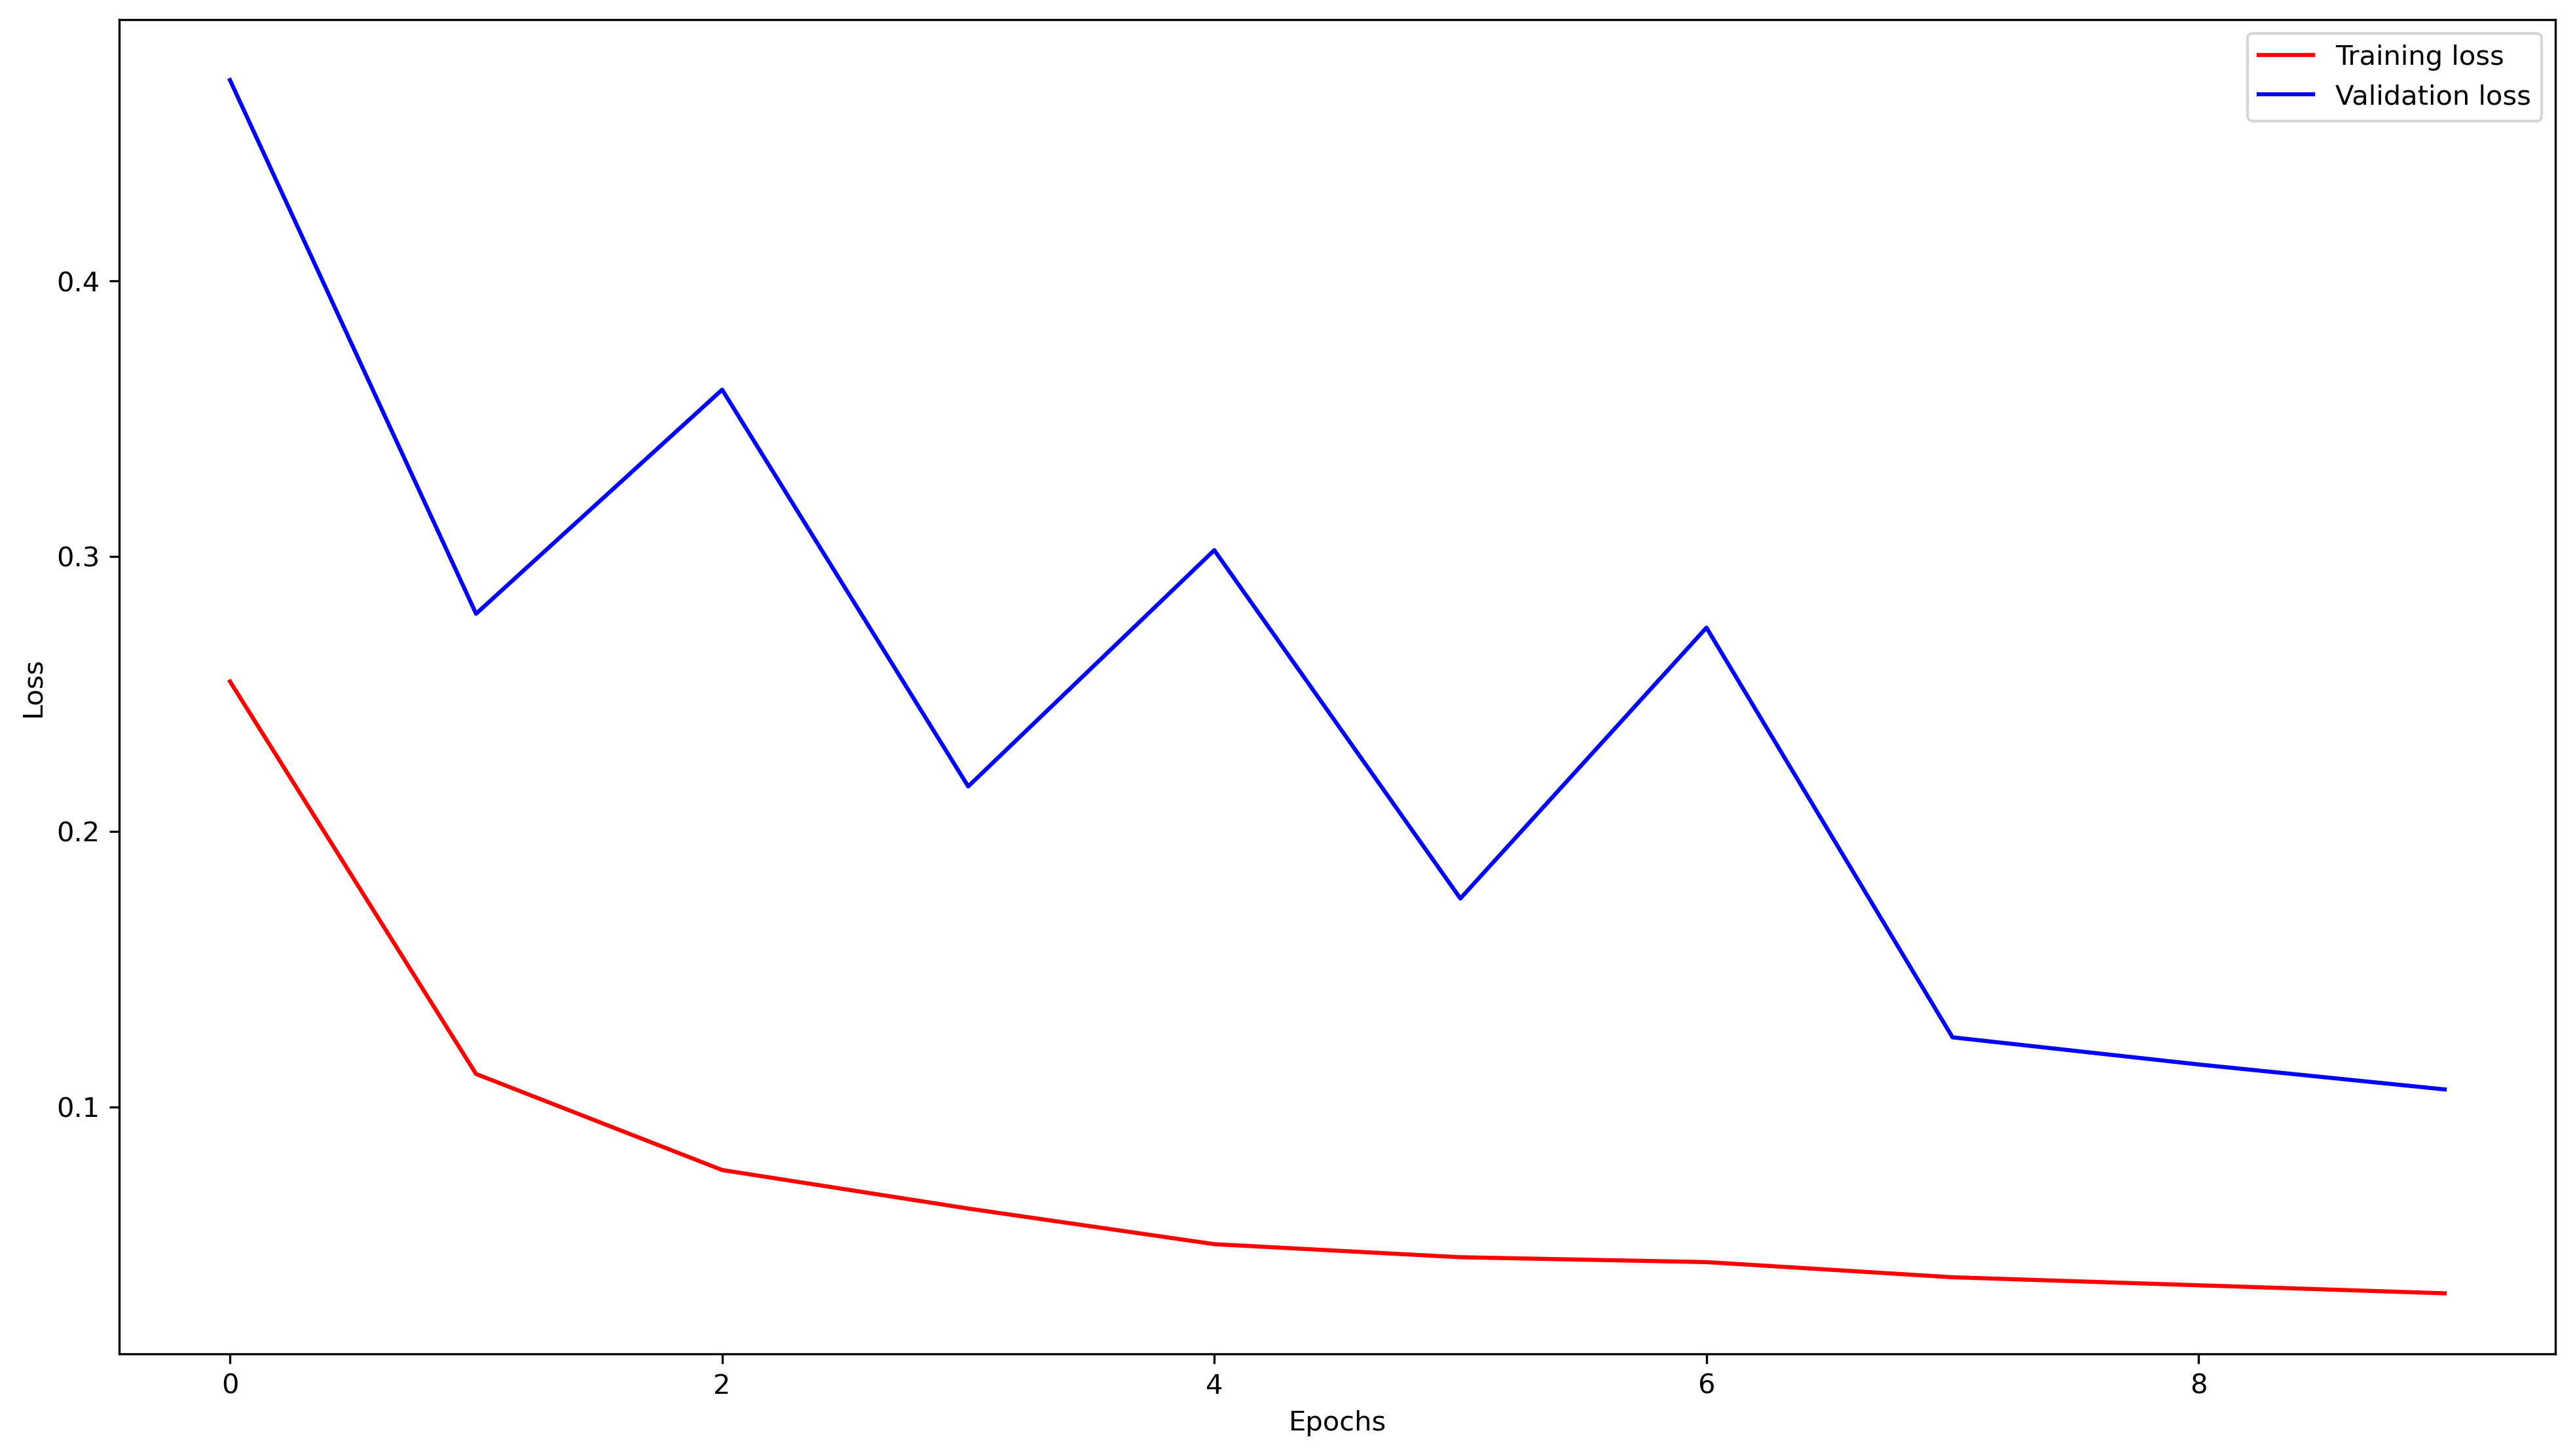

In [33]:
fig = plt.figure(dpi=300, figsize=(16,9))
plt.plot(np.arange(len(history['loss'])), history['loss'], color='r', label='Training loss')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], color='b', label = 'Validation loss')
#plt.scatter(validation_loss.index(min(validation_loss)), min(validation_loss), marker=(6, 1), c = 'r', s = 40)
plt.legend(["Training loss", "Validation loss"])
plt.xlabel('Epochs')
plt.ylabel('Loss')

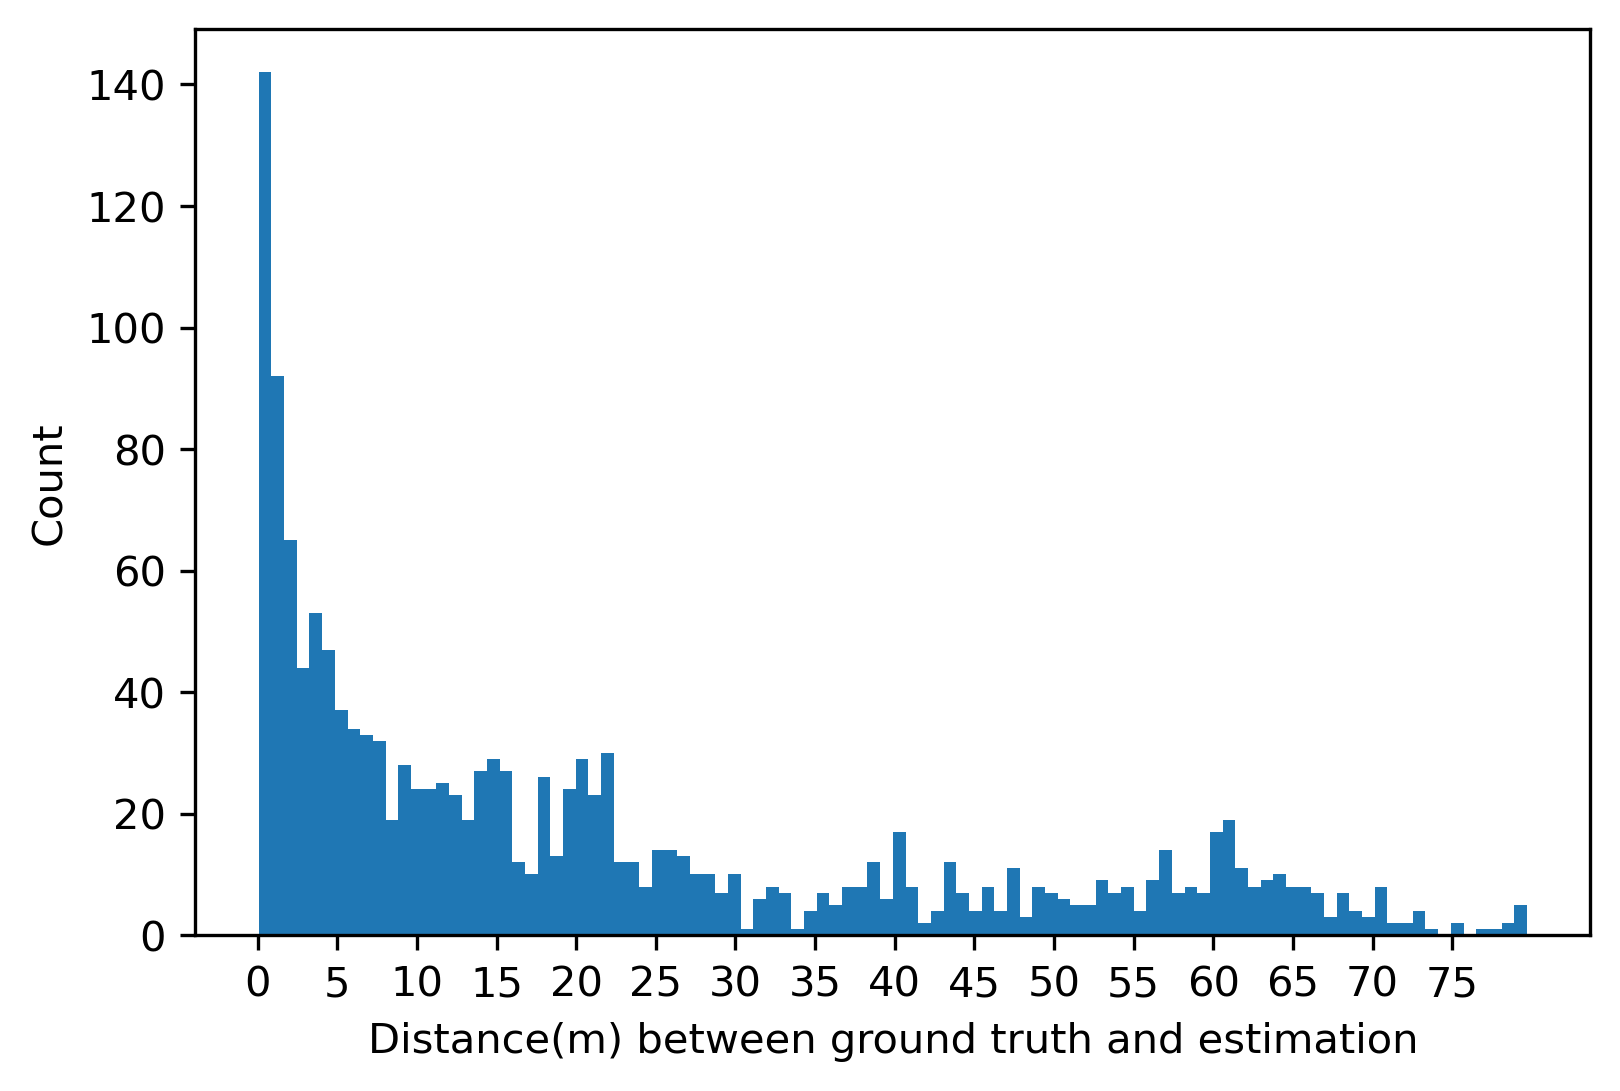

In [34]:
fig, ax = plt.subplots(dpi = 300)
ax.hist(dis, bins = 100)
ax.set_xticks(range(0,int(max(dis)),5))
ax.set_ylabel('Count')
ax.set_xlabel('Distance(m) between ground truth and estimation')
#plt.savefig('Highway_NN_Hist_middle_sample.png', dpi=300)
#plt.savefig('Highway_NN_Hist_middle_sample.svg')
plt.show()

In [35]:
import seaborn as sns
ax = sns.distplot(dis)
ax.set_xlabel('Distance(m) between ground truth and estimation')
#plt.savefig('Highway_NN_DisPlot_middle_sample.png', dpi=300)
#plt.savefig('Highway_NN_DisPlot_middle_sample.svg')

ModuleNotFoundError: No module named 'seaborn'